Aleksandr Lobanov (a.lobanov@innopolis.univesity)


B20-AI

# Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**


# 0. Prepare data

In [31]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    import matplotlib.pyplot
    import pandas as pd
    import json
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv("../information-retrieval/datasets/world.csv")
    
    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [32]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open("poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# pure coordinated in compressed representation, 2B per number -> 8MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float16)
N = len(dataset)
# free the memory
dataset = None
import gc
gc.collect()

0

Showing approximate dataset data distribution:

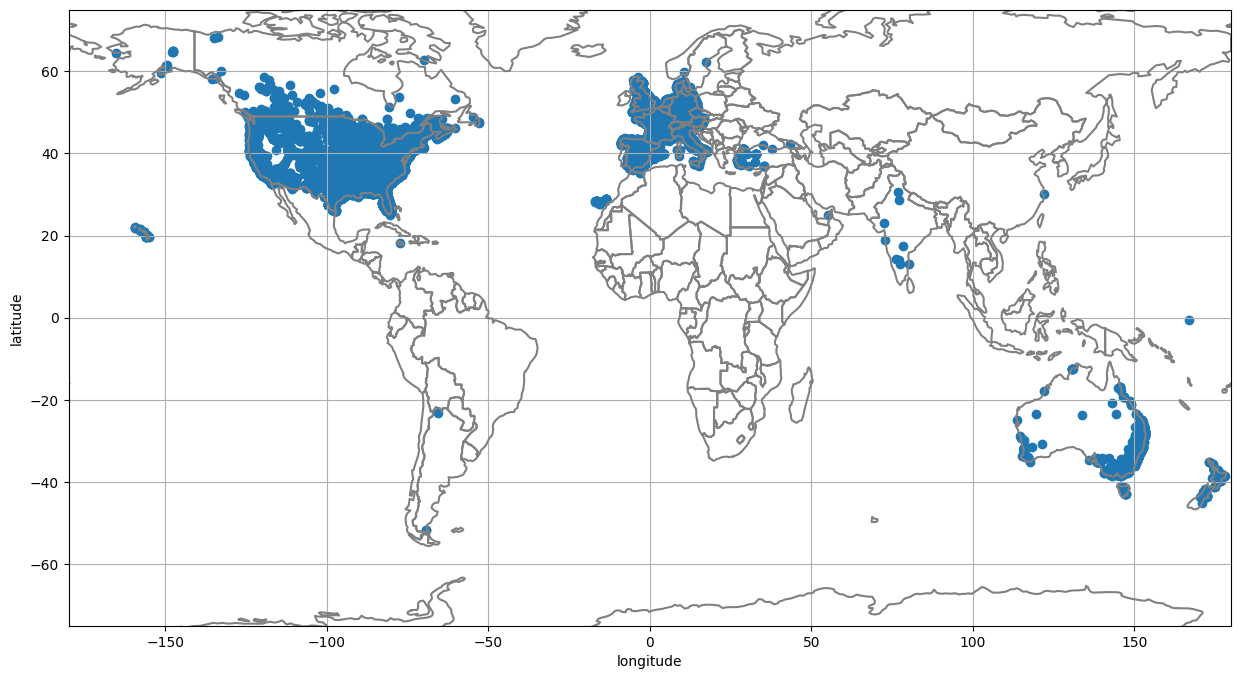

In [33]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [34]:
def split_shards(file, folder='shard', capacity=20000):
    import pickle, os, math, gc
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


# should return iterator, which goes through all elements, consequently opening files
# use ``yield`` operator to simplify your code
def iterate_dataset(num_items, folder_name="shard", capacity=20000):
    num_shards = (num_items // capacity) + (1 if num_items % capacity != 0 else 0)  # calculate the number of shards

    for i in range(num_shards):  # iterate through the shards
        with open(f"{folder_name}/{i}", 'rb') as f:  # open the shard file
            shard_data = pickle.load(f)  # load the shard data
            max_idx = capacity
            if i == num_shards - 1:  # check if this is the last shard
                max_idx = num_items % capacity  # adjust the maximum index to account for the remainder
            for idx in range(max_idx):  # iterate through the data in the shard
                yield shard_data[idx]  # yield each item in the shard data

In [35]:
split_shards("poi_sample01.pickle")

asserts:

In [36]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [37]:
import numpy as np

for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i,:], dataset_get([i])[0][0], atol=5*1e-2), ""

In [38]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius. Clarification: for simplicity **radius is given in units of coordinates (degrees)**, not kilometers or meters.

In [39]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [40]:
from sklearn.neighbors import BallTree

def build_geospacial_index(data_points, leaf_size=5) -> BallTree:
    """
    Builds a BallTree index for fast nearest-neighbor searches on geospatial data.
    
    Args:
    - data_points: A numpy array of shape (n_samples, n_dimensions) containing the data points
    - leaf_size: Maximum number of points in a leaf node of the tree
    
    Returns:
    - A BallTree object containing the index
    """
    return BallTree(data_points, leaf_size=leaf_size)


def kNN(query_point: list, k: int, index: BallTree) -> list:
    """
    Finds the k nearest neighbors to a given query point using a BallTree index.
    
    Args:
    - query_point: A numpy array of shape (n_dimensions,) containing the query point
    - k: Number of nearest neighbors to return
    - index: A BallTree object containing the index
    
    Returns:
    - A list of k data points nearest to the query point
    """
    _, result_index = index.query([query_point], k=k)  # find the k nearest neighbors
    return result_index[0]


def inRadius(query_point: list, radius: float, index: BallTree) -> list:
    """
    Finds all data points within a given radius of a query point using a BallTree index.
    
    Args:
    - query_point: A numpy array of shape (n_dimensions,) containing the query point
    - radius: Maximum distance from the query point to the returned points
    - index: A BallTree object containing the index
    
    Returns:
    - A list of data points within the given radius of the query point
    """
    return index.query_radius([query_point], r=radius)[0]  # find all points within the given radius using the index


In [41]:
GEO = GEO + np.random.normal(loc=0, scale=5E-4, size=GEO.shape)
spaidx = build_geospacial_index(GEO)

In [42]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 351, 11968, 15202, 15497, 16282, 23285, 24681, 26327]
[13, 145, 351, 11968, 15202, 15497, 16282, 23285, 24681, 26327, 27121]


## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. make sure they never coinside by adding insignificant noise)

Pass the assert to get full points.

In [43]:
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 1000, spaidx)
    assert (p in r), "Query did not return itself"

## 1.3. [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


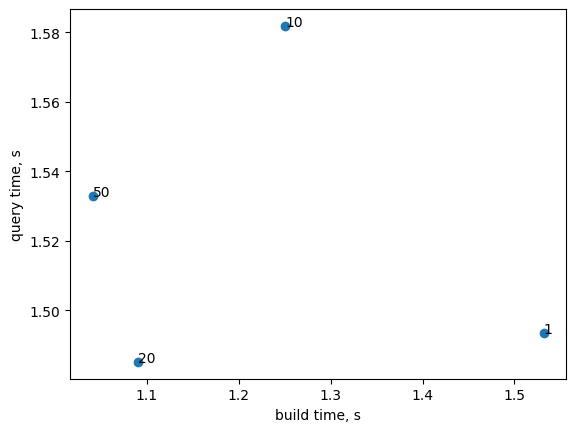

In [44]:
import random
import time
import matplotlib.pyplot as plt
import tqdm

queries = random.sample(range(N), 1000)
leaf_sizes = [1, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm.tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)
    
    start = time.time()
    for q in queries:
        d, r = spaidx.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [45]:
import numpy as np
from scipy.spatial import distance

def get_in_range(northeast, southwest, spacial_index, coordinates) -> list:
    """
    Returns a list of row indexes that fall within the rectangle defined by the northeast and southwest points.
    
    Parameters:
        northeast (list): A list containing the (latitude, longitude) of the northeast corner of the rectangle.
        southwest (list): A list containing the (latitude, longitude) of the southwest corner of the rectangle.
        spacial_index (object): A BallTree or KDTree object used for efficient k-nearest neighbor search.
        coordinates (numpy.array): An array of shape (n,2) containing the latitude and longitude coordinates of n points.
    
    Returns:
        list: A list of row indexes that fall within the rectangle.
    """
    # Convert coordinates to numpy arrays
    northeast = np.array(northeast)
    southwest = np.array(southwest)
    
    # Calculate the centroid of the rectangle
    centroid = (northeast + southwest) / 2
    
    # Calculate the radius of the circle circumscribed by the rectangle
    radius = distance.euclidean(northeast, southwest) / 2
    
    # Get all indexes within the radius of the centroid
    all_indexes = inRadius(centroid, radius, spacial_index)
    
    # Filter out the indexes that don't fall within the rectangle
    filtered_indexes = []
    for idx in all_indexes:
        point = coordinates[idx]
        if southwest[0] <= point[0] <= northeast[0] and southwest[1] <= point[1] <= northeast[1]:
            filtered_indexes.append(idx)
    
    return filtered_indexes

In [46]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [47]:
unique = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(unique))), "This Starbucks should be in place!"

print_starbucks(unique)

Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway
Starbucks, Coffee & Tea, . US, New York, 787 7th Ave
Starbucks, Coffee & Tea, . US, Manhattan, Hilton New York Marketplace 1335 Avenue of the Americas
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 1372 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 151 W 34th St
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks Coffee, Coffee & Tea, . US, New York, 1530 Broadway
Starbucks, Restaurant, . US, Manhattan, 195 Broadway


# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts to get full points.

In [48]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [49]:
# API_KEY = "MY_API_KEY"
API_KEY = "ce5cc677-2087-4157-881c-ef5fa657c106"

In [50]:
from geopy.geocoders import Yandex

def get_town_range_coordinates(town: str, yandex_geocode_api_key) -> tuple:
    """
    Returns a pair of tuples representing the latitude and longitude coordinates of the northeast and southwest corners
    of the rectangular boundary that encompasses the given town.
    
    Parameters:
        town (str): the name of the town to geocode.
        yandex_geocode_api_key (str): your Yandex Geocode API key.
    
    Returns:
        tuple: a pair of tuples representing the latitude and longitude coordinates of the northeast and southwest
        corners, respectively.
    """
    client = Yandex(api_key=yandex_geocode_api_key, timeout=10)
    response = client.geocode(town, exactly_one=True, timeout=None)
    bbox = response.raw['boundedBy']['Envelope']    
    return tuple(map(float, bbox['upperCorner'].split(' '))),\
          tuple(map(float, bbox['lowerCorner'].split(' ')))


If needed, request your key here: https://developers.google.com/maps/documentation/geocoding/get-api-key

Note, that from the **local machine** you may (!) need to have VPN enabled. For **colab** this should work smoothly.

In [51]:
# my_google_maps_api_key = open('google.key', 'r').read()
my_google_maps_api_key = "ce5cc677-2087-4157-881c-ef5fa657c106"

asserts:

In [52]:
p = get_town_range_coordinates('Pittsburgh downtown', my_google_maps_api_key)
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

((-79.989227, 40.453579), (-80.022159, 40.428417))


## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries! Pass the assert to get the points.

In [53]:
# should return dataset indices
def get_in_town(town, index, GEO, maps_api_key) -> list:
    coordinates = get_town_range_coordinates(town, maps_api_key)
    upper_corner, lower_corner = coordinates
    return get_in_range(upper_corner, lower_corner, index, GEO)

In [54]:
unique = get_in_town('Pittsburgh downtown', spaidx, GEO, my_google_maps_api_key)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(unique))), "This Starbucks should be in place!"

print_starbucks(unique)

Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave
Starbucks Coffee, Utilities, Mobile Phone. US, Pittsburgh, 1719 Penn Ave


## 2.3. [5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [55]:
global GEO_CACHE
GEO_CACHE = dict()

def get_town_range_coordinates_cached(town: str, maps_key: str) -> tuple:
    """Get coordinate ranges of towns. 

    If results persist 
    Args:
        town (str): address
        maps_key (str): geo-index 

    Returns:
        tuple: coordinates of the town
    """
    global GEO_CACHE
    if town not in GEO_CACHE:
        cords = get_town_range_coordinates(town, maps_key)
        GEO_CACHE[town] = cords    
    return GEO_CACHE[town]


def get_in_town_cached(town: str, index, GEO, maps_key: str) -> list:
    upper, lower = get_town_range_coordinates_cached(town, maps_key)
    return get_in_range(upper, lower, index, GEO)

In [56]:
unique = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(unique)
unique = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(unique)

Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [58]:
import spacy
nlp = spacy.load('en_core_web_md')
names = []

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait (and get **2 points**), but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices. Or maybe you want to use `fasttext` instead?

In [61]:
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

WORDS = set([a.strip() for a in open('../information-retrieval/datasets/words.txt', 'r').readlines()])
def embed(input_text, nlp):
    """
    Returns the normalized word embedding of a given input text.

    Args:
        input_text (str): The text to generate embeddings for.
        nlp (spacy.lang.en.English): The Spacy English language model instance.

    Returns:
        numpy.ndarray: A one-dimensional array of normalized word embeddings.
    """
    # Remove special characters from the text
    cleaned_text = re.sub(r'[^\w\s]', ' ', input_text)
    # Tokenize the text into words
    tokenized_words = word_tokenize(cleaned_text)
    # List to store valid words
    valid_words = []
    # Iterate over each word
    for word in tokenized_words:
        # Check if the word is in the vocabulary and not a stop word
        if word in WORDS and word not in stop_words:
            valid_words.append(word)
    
    # List to store embeddings of valid words
    word_embeddings = [nlp.vocab[word].vector for word in valid_words]
    # Calculate mean of the embeddings
    mean_embedding = np.mean(word_embeddings, axis=0)
    # Calculate L2 norm of the mean embedding
    l2_norm = np.linalg.norm(mean_embedding)
    # Normalize the mean embedding by dividing with L2 norm
    normalized_embedding = mean_embedding / l2_norm
    return normalized_embedding


In [62]:
from tqdm import tqdm
import gc
import numpy as np

embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

gc.collect()

  0%|          | 0/2173512 [00:00<?, ?it/s]d:\Projects\True_Hack_Project\.env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Projects\True_Hack_Project\.env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 154/2173512 [00:00<24:13, 1494.89it/s]C:\Users\Aleksandr\AppData\Local\Temp\ipykernel_13684\4213401438.py:39: RuntimeWarning: invalid value encountered in divide
  normalized_embedding = mean_embedding / l2_norm
100%|██████████| 2173512/2173512 [03:53<00:00, 9321.85it/s] 


0

## 3.2. [10 points] Vector index

Here you build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib (please refer to the corresponding lab). Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements to get full points:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should use cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index right on the disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [65]:
import numpy as np
from annoy import AnnoyIndex

def get_vector_index():
    """
    Builds an Annoy index for a given list of embeddings.

    Args:
        embeddings (list): A list of embeddings to build the index for.
        n_trees (int): The number of trees to build the index with.

    Returns:
        AnnoyIndex: An Annoy index for the embeddings.
    """
    # Create an Annoy index with 300 dimensions using the 'angular' distance metric
    annoy_idx = AnnoyIndex(300, 'angular')
    # Add each embedding to the Annoy index
    for idx, embedding in enumerate(embeddings):
        annoy_idx.add_item(idx, embedding)
    # Build the Annoy index using the specified number of trees and parallel jobs
    annoy_idx.build(37, n_jobs=-1)
    return annoy_idx


def get_kNN_embeddings(embedding, k, index):
    return index.get_nns_by_vector(embedding, k)

In [66]:
embedding_index = get_vector_index()

In [67]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [70]:
def find(town, query):
    """
    Finds the closest IDs to a given query within a town and returns the corresponding dataset entries.

    Args:
        town (str): The name of the town to search in.
        query (str): The query to search for.
        spaidx (dict): A dictionary mapping town names to IDs.
        GEO (dict): A dictionary containing geolocation data for each town.
        my_google_maps_api_key (str): A Google Maps API key.
        embeddings (list): A list of embeddings for the dataset.
        nlp (spacy.lang.en.English): The Spacy English language model instance.
        embedding_index (AnnoyIndex): An Annoy index for the embeddings.

    Returns:
        list: A list of dataset entries that match the query within the town.
    """
    # Get the set of IDs for the given town
    unique = set(get_in_town_cached(town, spaidx, GEO, my_google_maps_api_key))
    # Embed the query using the Spacy language model
    embedding = embed(query, nlp)

    # Find the indexes of embeddings that are closest to the query
    close_indexes = []
    for idx in unique:
        if embeddings[idx].any():
            close_indexes.append(idx)

    # Find the index of the closest embedding to the query
    closest_idx = get_kNN_embeddings(embedding, 1, embedding_index)[0]

    # Calculate the distance between each close index and the closest embedding
    candidates = []
    for idx in close_indexes:
        candidates.append((idx, embedding_index.get_distance(idx, closest_idx)))

    # Sort the candidates by distance and return the corresponding dataset entries
    candidates.sort(key=lambda x: x[1])
    ans = [x[0] for x in candidates]
    return dataset_get(ans)


In [71]:
items = find('Manhattan downtown, NY', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])

[([-73.980379, 40.751361], 'Jin Jie DMD, Health Services, Dentist. US, New York, 274 Madison Avenue'), ([-73.978302, 40.758701], 'Maryam Horri, DMD, Personal, Day Spa. US, New York, 45 Rockefeller Plz Ste 2710'), ([-74.023804, 40.855701], 'Grob Oscar DMD, Health Services, Dentist. US, Ridgefield Park, 255 Main St'), ([-73.974837, 40.761146], 'Derek Faktor, DMD, Health Services, Dentist. US, New York, 693 5th Ave Fl 14'), ([-73.923734, 40.770089], 'Renaissance OB-Gyn, Health Services, Doctor. US, Astoria, 2747 Crescent Street'), ([-73.970109, 40.763852], 'Gregory Chotkowski, DMD, Health Services, Doctor. US, New York, 30 E 60 St Ste 608'), ([-73.986702, 40.770372], 'Lustbader, Jerome DMD, Health Services, Dentist. US, New York, 200 Central Park S Ste 102'), ([-73.981622, 40.756248], 'Marks and Sabbagh DMD Llp, Health Services, Dentist. US, New York, 62 W 45th Street'), ([-73.943241, 40.839637], 'Columbia Dental North DMD, Health Services, Dentist. US, New York, 128 Fort Washington Avenu

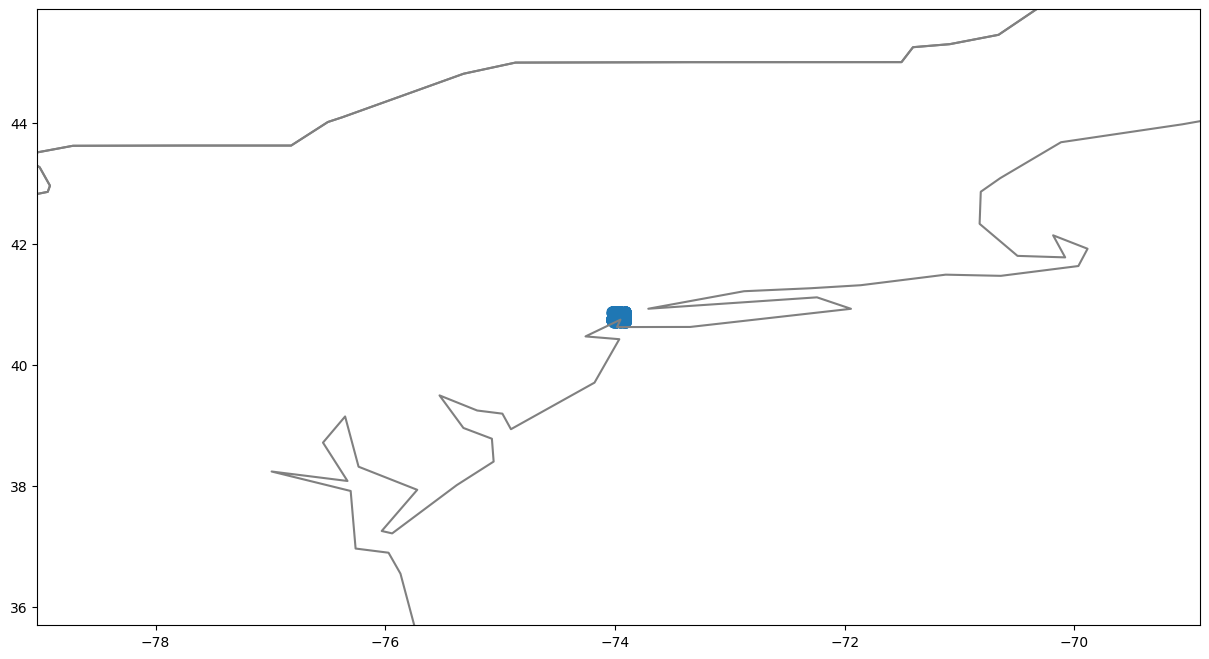

In [72]:
NE, SW = get_town_range_coordinates_cached('Manhattan downtown, NY', my_google_maps_api_key)
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()